# Assignment 1: Yield Curves

## 2.1 Fundamental Questions

### Q2: Selecting 10 Bonds to Construct Yield and Spot Curves

Canadian Government bond data including ISIN, coupon, yield, maturity date, issue date, issue price and historical time series close prices were collected from the following two links: 

* https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19
* https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19

This is done through web scraping via the `Selenium` Python package and will then be repackaged into a dataframe and saved as a .csv file. Full code can be found at `scrape.py`.

#### Pulling data for all bonds


In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt

In [2]:
df = pd.read_csv('bond_ts_9Feb.csv', index_col=0)
df.coupon = df.coupon.astype('float64')
df.maturityDate = pd.to_datetime(df.maturityDate)
df.issueDate = pd.to_datetime(df.issueDate)
df.head()

,coupon,yield,maturityDate,ISIN,issuePrice,issueDate,2/9,2/8,2/7,2/6,...,1/23,1/20,1/19,1/18,1/17,1/16,1/13,1/12,1/11,1/10
CAN 1.50 Jun 23,1.50,4.55,2023-06-01,CA135087A610,97.98,2012-07-30,99.11,99.09,99.07,99.06,...,98.96,98.95,98.95,98.94,98.92,98.92,98.91,98.91,98.88,98.86
CAN 2.50 Jun 24,2.50,4.33,2024-06-01,CA135087B451,98.99,2013-07-02,97.77,97.72,97.70,97.74,...,98.02,98.05,98.11,98.17,98.07,98.08,98.04,97.97,97.92,97.83
CAN 2.25 Jun 25,2.25,3.68,2025-06-01,CA135087D507,98.85,2014-06-30,96.98,96.88,96.86,96.94,...,97.43,97.51,97.68,97.70,97.45,97.45,97.26,97.05,96.92,96.74
CAN 1.75 Mar 23,1.75,NaN,2023-03-01,CA135087H490,99.56,2017-10-06,99.89,99.86,99.86,99.85,...,99.75,99.74,99.72,99.72,99.70,99.71,99.70,99.68,99.67,99.64
CAN 2.25 Mar 24,2.25,4.49,2024-03-01,CA135087J546,98.99,2018-10-05,97.77,97.74,97.70,97.72,...,97.86,97.87,97.92,97.95,97.87,97.93,97.91,97.87,97.85,97.77


These bond prices were scraped on Feb 9th to get the latest historical close prices. Yields reflected are thus as of Feb 9th 2023. To keep things simple, all available historical close prices were scraped from the 1 month chart however only prices between **16th Jan - 27th Jan** are used. This forms our period of 10 days/2 weeks of data. The index of the dataframe is how we refer to a bond. *"CAN 1.50 Jun 23"* refers to the Canadian Government Bond with a maturity in June 2023 and a coupon of 1.50.

In [3]:
df.drop(['2/9', '2/8', '2/7', '2/6', '2/3', '2/2', '2/1', '1/31',
       '1/30', '1/13', '1/12', '1/11', '1/10'], axis=1, inplace=True)
df.head()

,coupon,yield,maturityDate,ISIN,issuePrice,issueDate,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 1.50 Jun 23,1.50,4.55,2023-06-01,CA135087A610,97.98,2012-07-30,99.00,99.00,99.00,98.98,98.96,98.95,98.95,98.94,98.92,98.92
CAN 2.50 Jun 24,2.50,4.33,2024-06-01,CA135087B451,98.99,2013-07-02,97.96,98.07,98.07,98.01,98.02,98.05,98.11,98.17,98.07,98.08
CAN 2.25 Jun 25,2.25,3.68,2025-06-01,CA135087D507,98.85,2014-06-30,97.35,97.56,97.54,97.39,97.43,97.51,97.68,97.70,97.45,97.45
CAN 1.75 Mar 23,1.75,NaN,2023-03-01,CA135087H490,99.56,2017-10-06,99.79,99.78,99.77,99.76,99.75,99.74,99.72,99.72,99.70,99.71
CAN 2.25 Mar 24,2.25,4.49,2024-03-01,CA135087J546,98.99,2018-10-05,97.84,97.92,97.92,97.87,97.86,97.87,97.92,97.95,97.87,97.93


#### Selecting 10 Bonds to plot Yield and Spot Curves

Now, 10 bonds which will be chosen to form our new dataframe to construct 0-5 year yield and spot curves. Since we only have to plot yield and spot curves for bonds maturing within 5 years, only bonds with maturity dates up till Dec 2027 will be considered.

In [4]:
df.sort_values('maturityDate').loc[df['maturityDate'] < '2028-01-02']

,coupon,yield,maturityDate,ISIN,issuePrice,issueDate,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 0.25 Feb 23,0.25,NaN,2023-02-01,CA135087L773,99.94,2020-10-26,99.99,99.98,99.94,99.93,99.92,99.91,99.90,99.87,99.86,99.84
CAN 1.75 Mar 23,1.75,NaN,2023-03-01,CA135087H490,99.56,2017-10-06,99.79,99.78,99.77,99.76,99.75,99.74,99.72,99.72,99.70,99.71
CAN 0.25 May 23,0.25,4.51,2023-05-01,CA135087L856,100.05,2021-02-05,98.97,98.96,98.94,98.92,98.91,98.89,98.88,98.86,98.85,98.84
CAN 1.50 Jun 23,1.50,4.55,2023-06-01,CA135087A610,97.98,2012-07-30,99.00,99.00,99.00,98.98,98.96,98.95,98.95,98.94,98.92,98.92
CAN 8.00 Jun 23,8.00,4.51,2023-06-01,CA135087UT96,98.00,1992-08-17,101.13,101.14,101.20,101.19,101.19,101.20,101.21,101.27,101.26,101.28
CAN 0.25 Aug 23,0.25,4.56,2023-08-01,CA135087M359,99.69,2021-05-14,97.90,97.91,97.90,97.87,97.84,97.83,97.84,97.83,97.80,97.80
CAN 0.50 Nov 23,0.50,4.58,2023-11-01,CA135087M763,99.90,2021-08-09,97.07,97.10,97.11,97.06,97.03,97.01,97.05,97.05,97.01,97.02
CAN 0.75 Feb 24,0.75,4.60,2024-02-01,CA135087M920,99.73,2021-10-22,96.40,96.46,96.47,96.41,96.40,96.38,96.46,96.47,96.44,96.46
CAN 2.25 Mar 24,2.25,4.49,2024-03-01,CA135087J546,98.99,2018-10-05,97.84,97.92,97.92,97.87,97.86,97.87,97.92,97.95,97.87,97.93
CAN 0.25 Apr 24,0.25,4.45,2024-04-01,CA135087L690,99.86,2020-10-16,95.51,95.60,95.59,95.52,95.52,95.49,95.54,95.55,95.44,95.49


Of the above, only 10 bonds will be chosen. Thus, 2 bonds will be chosen each year from 2023 till 2027 with equally spaced maturity dates and relatively similar coupon payments. The following 10 bonds are thus chosen:
* CAN 0.25 May 23
* CAN 0.50 Nov 23
* CAN 1.50 May 24
* CAN 0.75 Oct 24
* CAN 1.50 Apr 25
* CAN 0.50 Sep 25
* CAN 0.25 Mar 26
* CAN 1.00 Sep 26
* CAN 1.25 Mar 27
* CAN 2.75 Sep 27

In [5]:
bonds = df.loc[['CAN 0.25 May 23', 'CAN 0.50 Nov 23', 'CAN 1.50 May 24', 'CAN 0.75 Oct 24', 'CAN 1.50 Apr 25', 'CAN 0.50 Sep 25', 'CAN 0.25 Mar 26', 'CAN 1.00 Sep 26', 'CAN 1.25 Mar 27', 'CAN 2.75 Sep 27']]
bonds.sort_values(by = ['maturityDate'], inplace = True)
bonds

,coupon,yield,maturityDate,ISIN,issuePrice,issueDate,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 0.25 May 23,0.25,4.51,2023-05-01,CA135087L856,100.05,2021-02-05,98.97,98.96,98.94,98.92,98.91,98.89,98.88,98.86,98.85,98.84
CAN 0.50 Nov 23,0.50,4.58,2023-11-01,CA135087M763,99.90,2021-08-09,97.07,97.10,97.11,97.06,97.03,97.01,97.05,97.05,97.01,97.02
CAN 1.50 May 24,1.50,4.41,2024-05-01,CA135087N423,99.85,2022-02-22,96.76,96.86,96.85,96.79,96.79,96.82,96.89,96.92,96.80,96.85
CAN 0.75 Oct 24,0.75,4.15,2024-10-01,CA135087M508,99.97,2021-07-12,95.01,95.15,95.14,95.05,95.06,95.09,95.19,95.25,95.14,95.10
CAN 1.50 Apr 25,1.50,3.87,2025-04-01,CA135087N340,99.74,2022-01-24,95.67,95.87,95.84,95.68,95.72,95.79,95.95,95.96,95.76,95.72
CAN 0.50 Sep 25,0.50,3.70,2025-09-01,CA135087K940,99.63,2020-04-03,92.72,93.00,92.97,92.81,92.82,92.87,93.03,93.03,92.75,92.74
CAN 0.25 Mar 26,0.25,3.53,2026-03-01,CA135087L518,99.03,2020-10-09,91.17,91.45,91.41,91.21,91.23,91.32,91.51,91.43,91.19,91.08
CAN 1.00 Sep 26,1.00,3.38,2026-09-01,CA135087L930,99.66,2021-04-16,92.77,93.04,93.05,92.91,92.90,92.95,93.29,93.24,92.84,92.72
CAN 1.25 Mar 27,1.25,3.28,2027-03-01,CA135087M847,99.66,2021-10-15,93.14,93.46,93.50,93.35,93.33,93.39,93.78,93.73,93.25,93.14
CAN 2.75 Sep 27,2.75,3.20,2027-09-01,CA135087N837,99.30,2022-05-13,98.86,99.24,99.29,99.15,99.14,99.24,99.71,99.71,99.22,99.10


## 2.2 Empirical Questions

### Q4a: Yield Curve

#### Finding yield to maturity
We will solve for yield to maturity based on the following generic formula:

$$
   P = \sum_{i}^{n} p_ie^{-r(t_i)t{i}} 
$$
 
* $P$ = bond price (dirty price)
* $n$ = number of time steps 
* $p_i$ = coupon payment at time $t=i$. 
    * When $i=n$, $p_i = p_n + FV$ where $p_n$ is the final coupon payment
* $r(t_i)$ = yield to maturity
* $t_i$ = time to coupon payment. $t_n$ is the time to maturity
* $FV$ = face value of bond

First, we have to calculate each bond's time to maturity and how many more periods of coupon payments it has. To find how many more periods or coupon payments it has, we round up its time to maturity to the nearest 0.5 years and multiply by 2.

In [6]:
from dateutil.relativedelta import relativedelta

ttm_all = np.zeros(10)
periods_all = np.zeros(10)

for i in range(bonds.shape[0]):
    maturity = bonds.iloc[i,2]
    date_delta = relativedelta(maturity, dt.datetime(2023,2,9))
    ttm_i = date_delta.years + date_delta.months/12 + date_delta.days/365
    ttm_all[i] = ttm_i
    period_i = round((ttm_i + 0.5) * 2)/2
    periods_all[i] = int(period_i*2)
    
bonds['ttm'] = ttm_all
bonds['periods'] = periods_all
bonds

,coupon,yield,maturityDate,ISIN,issuePrice,issueDate,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16,ttm,periods
CAN 0.25 May 23,0.25,4.51,2023-05-01,CA135087L856,100.05,2021-02-05,98.97,98.96,98.94,98.92,98.91,98.89,98.88,98.86,98.85,98.84,0.226941,1.0
CAN 0.50 Nov 23,0.50,4.58,2023-11-01,CA135087M763,99.90,2021-08-09,97.07,97.10,97.11,97.06,97.03,97.01,97.05,97.05,97.01,97.02,0.729680,2.0
CAN 1.50 May 24,1.50,4.41,2024-05-01,CA135087N423,99.85,2022-02-22,96.76,96.86,96.85,96.79,96.79,96.82,96.89,96.92,96.80,96.85,1.226941,3.0
CAN 0.75 Oct 24,0.75,4.15,2024-10-01,CA135087M508,99.97,2021-07-12,95.01,95.15,95.14,95.05,95.06,95.09,95.19,95.25,95.14,95.10,1.643607,4.0
CAN 1.50 Apr 25,1.50,3.87,2025-04-01,CA135087N340,99.74,2022-01-24,95.67,95.87,95.84,95.68,95.72,95.79,95.95,95.96,95.76,95.72,2.146347,5.0
CAN 0.50 Sep 25,0.50,3.70,2025-09-01,CA135087K940,99.63,2020-04-03,92.72,93.00,92.97,92.81,92.82,92.87,93.03,93.03,92.75,92.74,2.563014,6.0
CAN 0.25 Mar 26,0.25,3.53,2026-03-01,CA135087L518,99.03,2020-10-09,91.17,91.45,91.41,91.21,91.23,91.32,91.51,91.43,91.19,91.08,3.054795,7.0
CAN 1.00 Sep 26,1.00,3.38,2026-09-01,CA135087L930,99.66,2021-04-16,92.77,93.04,93.05,92.91,92.90,92.95,93.29,93.24,92.84,92.72,3.563014,8.0
CAN 1.25 Mar 27,1.25,3.28,2027-03-01,CA135087M847,99.66,2021-10-15,93.14,93.46,93.50,93.35,93.33,93.39,93.78,93.73,93.25,93.14,4.054795,9.0
CAN 2.75 Sep 27,2.75,3.20,2027-09-01,CA135087N837,99.30,2022-05-13,98.86,99.24,99.29,99.15,99.14,99.24,99.71,99.71,99.22,99.10,4.563014,10.0


#### Trial and Error approach to solve for yield to maturity

Based on the above equation, there is no easy way to solve for $r(t_i)$. Thus, we need to develop and algorithm that guess $r(t_i)$ by matching its dirty price, $P$, which we have scraped off the given links, to a `get_price` function that discounts all future cashflows.

In [7]:
def get_price(coupon, ytm, ttm, periods, face_value=100):
    price = 0
    for i in range(1, int(periods)):
        ti = ttm - 0.5*i
        price += coupon * math.exp(-ytm * ti)
    price += (coupon + face_value) * math.exp(-ytm * ttm)
    return price 
        
def get_ytm(curr_price, coupon, ttm, periods, face_value=100):
    ytm = coupon/100
    
    flag = True
    while flag:
        if (curr_price < face_value):
            ytm += 0.000001
        else:
            ytm -= 0.000001
        
        price = get_price(coupon, ytm, ttm, periods)
        
        if (curr_price < face_value):
            flag = price > curr_price
        else:
            flag = price < curr_price
    
    return ytm*100

In [8]:
dates = ['1/27', '1/26', '1/25', '1/24', '1/23', '1/20', '1/19', '1/18', '1/17', '1/16']

ytm_dict = {}
for k1 in bonds.index:
    ytm_dict[k1] = {}
    for d in dates:
        ytm_dict[k1][d] = None
                
for i in range(len(dates)):
    date = dates[i]
    day_s = bonds.loc[:,dates[i]]
    
    for j in range(len(day_s)):
        bond_j = day_s.index[j]
        close = day_s[j]
        periods = bonds.loc[bond_j, 'periods']
        coupon = bonds.loc[bond_j, 'coupon']/2
        ttm = bonds.loc[bond_j, 'ttm']
        
        ytm_day = get_ytm(close, coupon, ttm, periods)
        ytm_dict[bond_j][date] = ytm_day
        
bonds_ytm = pd.DataFrame.from_dict(ytm_dict)
bonds_ytm = bonds_ytm.T
bonds_ytm

,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 0.25 May 23,5.1127,5.1572,5.2463,5.3353,5.3799,5.4690,5.5136,5.6027,5.6473,5.6919
CAN 0.50 Nov 23,4.7673,4.7248,4.7107,4.7814,4.8238,4.8521,4.7955,4.7955,4.8521,4.8380
CAN 1.50 May 24,4.5395,4.4545,4.4630,4.5140,4.5140,4.4885,4.4290,4.4035,4.5055,4.4630
CAN 0.75 Oct 24,4.0482,3.9580,3.9644,4.0224,4.0160,3.9966,3.9322,3.8936,3.9644,3.9902
CAN 1.50 Apr 25,3.8442,3.7451,3.7600,3.8392,3.8194,3.7847,3.7056,3.7006,3.7996,3.8194
CAN 0.50 Sep 25,3.5565,3.4380,3.4507,3.5184,3.5142,3.4930,3.4253,3.4253,3.5438,3.5481
CAN 0.25 Mar 26,3.3261,3.2253,3.2397,3.3117,3.3045,3.2721,3.2037,3.2325,3.3189,3.3586
CAN 1.00 Sep 26,3.2714,3.1882,3.1851,3.2282,3.2313,3.2159,3.1113,3.1266,3.2498,3.2869
CAN 1.25 Mar 27,3.1899,3.1028,3.0919,3.1327,3.1381,3.1218,3.0160,3.0296,3.1599,3.1899
CAN 2.75 Sep 27,3.2798,3.1899,3.1780,3.2111,3.2135,3.1899,3.0791,3.0791,3.1946,3.2230


#### Plotting Yield Curve

Now that we have our 10 bond's yield to maturities, we can plot a 5-year yield curve with each day of data superimposed on-top of each other. To do this, we will have to interpolate the yields for different maturity terms for the bonds and we will use the `scipy.interpolate.CubicSpline` method from the `scipy` library to help us.

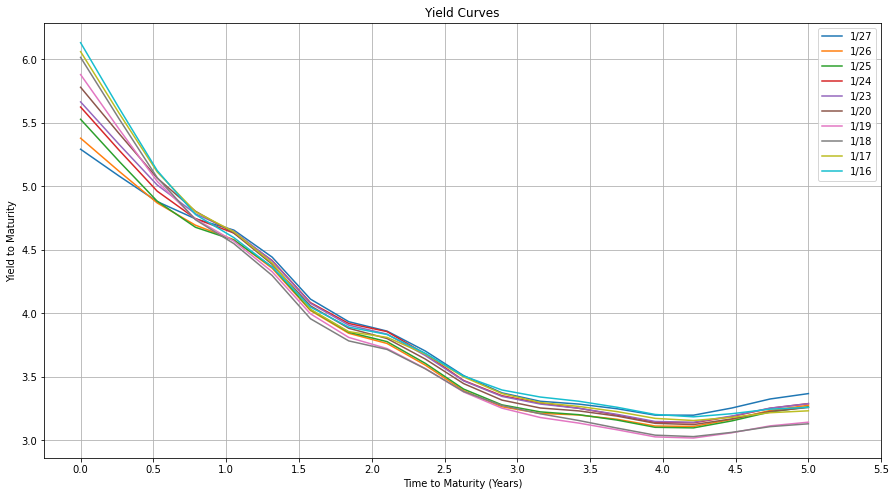

In [9]:
import scipy.interpolate
import matplotlib.pyplot as plt

all_ytm = []
X = np.linspace(0,5,20)
for d in bonds_ytm:
    out = scipy.interpolate.CubicSpline(x=bonds['ttm'].values, y=bonds_ytm[d].values, bc_type='natural')
    all_ytm.append(out(X))
    
plt.figure(figsize=(15,8))

for i in range(len(dates)):
    plt.plot(X, all_ytm[i], label=dates[i])
    
plt.title('Yield Curves')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Yield to Maturity')
plt.xticks(np.arange(0, 6, 0.5))
plt.grid()
plt.legend()
plt.show();

### Q4b: Spot Curve

The spot rate of a bond is the current yield for a given term and is the yield to maturity of zero-coupon bonds with those terms. The spot curve is thus constructed from  the prices of zero-coupon bonds and represents the theoretical yields of zero-coupon bonds of different maturities at a specific point in time. However, not enough zero-coupon bonds are trading in the market to clearly indicate what actual bonds prices would be at a given maturity. In addition, Canadian Government Bonds are treasury coupon bonds with coupon payments and not zero-coupon bonds, they cannot be used to find the spot rate curve directly. 

#### Bootstrapping
Spot rate curves implied by market prices can be determined from the market prices of coupon bonds through a process called bootstrapping. Bootstrapping involves obtaining spot rates or zero-coupon rates for one period, then using that spot rate to determine the 2-period spot rate, and so on.

Since a coupon bond can be considered as a group of zero-coupon bonds with a zero corresponding to each coupon payment and to the final principal repayment, each cash flow should be discounted at the interest rate appropriate for the period in which the cash flow will be received. Eventually, the value of zero-coupon  bonds must equal the coupon bond, otherwise there would be a risk-free arbitrage opportunity from striping the initial coupon bond and selling the constituent zero-coupon bonds for a profit.

Therefore, a theoretical spot rate cruve can be constructed through the process of bootstrapping by considering the value of zero coupon bonds equivalent to Canadian Government treasury bonds. The calculated rates can then construct the spot-rate cruve by adding the yields for each term to the desired maturity.

#### Finding Spot Rates
The spot rate is first calculated for the 6-month bond that has a known market price that only has a single payment left. In this case, that is our bond maturing in May 2023, `CAN 0.25 May 23`. This spot rate is essentially the yield to maturity calculated previously.

After the spot rate is calculated for the 6-month bond, we can use said spot rate to calculate rate for the 2nd period of the 1-year bond. In this case, it's our bond maturing in Nov 2023, `CAN 0.50 Nov 23` which has 2 repayments left. This iterative process is repeated for all subsequent bonds where we will use a cumulative sum of previous bonds' discounted price. This process is called bootstrapping as prior calculated spot rates are used to calculate later spot rates.

We use the following equation to calculate the spot rate for subsequent bonds. This is because continuously compounded interest rates produce more accurate results. 

$$
r(t_n) = \frac{lg(p_n)-lg(P-\sum_{i}^{n-1}p_ie^{r(t_i)t_i})}{t_n}
$$

where
* $t_n$ = time to maturity
* $t_i$ = number of periods to $t_n$
* $r(t_n)$ = spot rate for bond with time to maturity = $t_n$
* $P$ = bond price (dirty price)
* $p_n$ = $FV + p_{n-1}$ where $p_{n-1}$ is the final coupon payment
* $p_i$ = previous coupon payments at time $i$
    * e.g For a coupon bond maturing in 1.5 years, it will have 3 repayments left. Hence $p_1$ = coupon payment in 6 months, $p_2$ = coupon payment in 1 year, and $p_3$ = coupon payment in 1.5 years.

In [10]:
dates = ['1/27', '1/26', '1/25', '1/24', '1/23', '1/20', '1/19', '1/18', '1/17', '1/16']

spot_dict = {}
for k1 in bonds.index:
    spot_dict[k1] = {}
    for d in dates:
        spot_dict[k1][d] = None

for i in range(len(dates)):
    date = dates[i]
    b = 'CAN 0.25 May 23'
    s1 = ytm_dict[b][date]/100
    spot_dict[b][date] = s1
    
bonds_spot = pd.DataFrame.from_dict(spot_dict)
bonds_spot = bonds_spot.T
bonds_spot

,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 0.25 May 23,0.051127,0.051572,0.052463,0.053353,0.053799,0.05469,0.055136,0.056027,0.056473,0.056919
CAN 0.50 Nov 23,None,None,None,None,None,None,None,None,None,None
CAN 1.50 May 24,None,None,None,None,None,None,None,None,None,None
CAN 0.75 Oct 24,None,None,None,None,None,None,None,None,None,None
CAN 1.50 Apr 25,None,None,None,None,None,None,None,None,None,None
CAN 0.50 Sep 25,None,None,None,None,None,None,None,None,None,None
CAN 0.25 Mar 26,None,None,None,None,None,None,None,None,None,None
CAN 1.00 Sep 26,None,None,None,None,None,None,None,None,None,None
CAN 1.25 Mar 27,None,None,None,None,None,None,None,None,None,None
CAN 2.75 Sep 27,None,None,None,None,None,None,None,None,None,None


In [11]:
for d in range(len(dates)):
    date = dates[d]
    day_s = bonds_spot.loc[:,dates[d]]
    
    for n in range(1, len(day_s)):
        b_n = day_s.index[n]
        pi = bonds.loc[b_n, 'coupon']/2
        pn = 100 + pi
        P = bonds.loc[b_n, date]
        ttm = bonds.loc[b_n, 'ttm']

        prevSum = 0
        for i in range(n):
            ti = ttm - 0.5*(n-i)
            r_ti = bonds_spot.iloc[0][date]
            prevSum += pi*math.exp(-r_ti*ti)
        
        s_day = (np.log(pn) - np.log(P-prevSum)) / ttm
        
        bonds_spot.at[b_n, date] = s_day
        
bonds_spot = bonds_spot*100
bonds_spot

,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 0.25 May 23,5.1127,5.1572,5.2463,5.3353,5.3799,5.469,5.5136,5.6027,5.6473,5.6919
CAN 0.50 Nov 23,4.766928,4.724436,4.710215,4.780904,4.823342,4.851594,4.794918,4.794846,4.851451,4.837253
CAN 1.50 May 24,4.536015,4.450269,4.458286,4.509042,4.508778,4.482605,4.422534,4.396389,4.498647,4.455651
CAN 0.75 Oct 24,4.043378,3.952555,3.958626,4.016476,4.009802,3.989984,3.925097,3.885921,3.956837,3.982519
CAN 1.50 Apr 25,3.827945,3.727083,3.740988,3.820108,3.799471,3.76324,3.682534,3.67641,3.776039,3.795541
CAN 0.50 Sep 25,3.548239,3.42884,3.441125,3.508732,3.504242,3.482496,3.414239,3.413777,3.532665,3.536694
CAN 0.25 Mar 26,3.320229,3.218926,3.233072,3.305043,3.297668,3.264855,3.19615,3.224717,3.31128,3.350954
CAN 1.00 Sep 26,3.242557,3.157369,3.152884,3.195307,3.197757,3.180759,3.073941,3.088179,3.212481,3.249406
CAN 1.25 Mar 27,3.146271,3.056352,3.043301,3.082975,3.087552,3.068944,2.95996,2.971848,3.103944,3.133567
CAN 2.75 Sep 27,3.175757,3.078561,3.061247,3.091211,3.091266,3.06154,2.942604,2.937802,3.056851,3.084284


#### Plotting Spot Curve

Now that we have our 10 bond's spot rates across all 10 days, we can plot a 5-year spot curve.

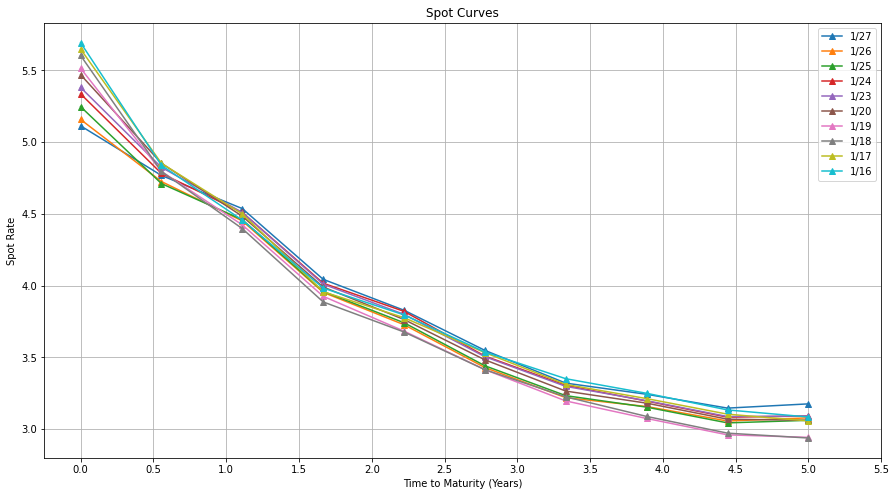

In [12]:
X = np.linspace(0,5,10)
plt.figure(figsize=(15,8))

for i in range(len(dates)):
    plt.plot(X, bonds_spot.iloc[:, i].values, label=dates[i], marker='^')
    
plt.title('Spot Curves')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Spot Rate')
plt.xticks(np.arange(0, 6, 0.5))
plt.grid()
plt.legend()
plt.show();

### Q4c: Forward Curve

Closely related to the spot rate is the forward rate, which is the interest rate for a certain term that begins in the future and ends later. Since such future interest rates are unknown, the forward rates are calculated from current bond prices and are sometimes called implied forward rates since they are implied by the bond market prices in the same way implied volatility is determined by option market prices.

#### Finding Forward Rates

The forward curve discounts a single payment, just not till today. In our case, we have to discount all future payments at varying maturities from 2-5 years till 1 year from now. 

We can find forward rates via the following formula:

$$
e^{r_{t_2} \cdot t_2} = e^{r_{t_1} \cdot t_1} \cdot e^{r_{t_1,t_2} \cdot (t_2 - t_1)}
$$

where
* $t_1$ = future time period to discount to
* $t_2$ = future time period that bond matures
* $r_{t_n}$ = spot rate for time period $(0,t_n)$
* $r_{t_1, t_2}$ = forward rates, i.e future interest rate for time period $(t_1,t_2)$

Since we already have our spot rate curve, we can solve for $r_{1,2}$ and we get:

$$
f(t_1,t_2) = r_{t_1, t_2} = \frac{r_{t_2} \cdot t_2 - r_{t_1} \cdot t_1}{t_2 - t_1}
$$

In our case, $t_1$ = 1 year from now and hence $r_{t_1,t_2}$ ranges from 1yr-1yr, 1yr-2yr, ... 1yr-4yr ending at 2027. Thus, we will have to use `CAN 0.25 May 23` as the bond maturing at time $t_1$ and every subsequent bond maturing in March or April from 2024 to 2027 to compute our forward rates.

In [13]:
bonds_forwards = bonds_spot.loc[['CAN 0.25 May 23', 'CAN 1.50 May 24', 'CAN 1.50 Apr 25', 'CAN 0.25 Mar 26', 'CAN 1.25 Mar 27']]
bonds_forwards

,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 0.25 May 23,5.1127,5.1572,5.2463,5.3353,5.3799,5.469,5.5136,5.6027,5.6473,5.6919
CAN 1.50 May 24,4.536015,4.450269,4.458286,4.509042,4.508778,4.482605,4.422534,4.396389,4.498647,4.455651
CAN 1.50 Apr 25,3.827945,3.727083,3.740988,3.820108,3.799471,3.76324,3.682534,3.67641,3.776039,3.795541
CAN 0.25 Mar 26,3.320229,3.218926,3.233072,3.305043,3.297668,3.264855,3.19615,3.224717,3.31128,3.350954
CAN 1.25 Mar 27,3.146271,3.056352,3.043301,3.082975,3.087552,3.068944,2.95996,2.971848,3.103944,3.133567


In [14]:
for d in range(len(dates)):
    day_s = bonds_forwards.iloc[:, d]
    
    for i in range(1, len(day_s)):
        r_t2 = bonds_forwards.iloc[i, d]
        t2 = i+1
        r_t1 = bonds_forwards.iloc[0, d]
        t1 = 1
        
        f_t1t2 = (r_t2 * t2 - r_t1 * t1)/(t2-t1)
        
        bonds_forwards.iloc[i, d] = f_t1t2
        
bonds_forwards = bonds_forwards.iloc[1:,:]
bonds_forwards

,1/27,1/26,1/25,1/24,1/23,1/20,1/19,1/18,1/17,1/16
CAN 1.50 May 24,3.959329,3.743338,3.670271,3.682783,3.637655,3.49621,3.331468,3.190079,3.349993,3.219401
CAN 1.50 Apr 25,3.185567,3.012024,2.988332,3.062513,3.009257,2.910361,2.767001,2.713266,2.840408,2.847362
CAN 0.25 Mar 26,2.722739,2.572834,2.561996,2.628291,2.60359,2.53014,2.423667,2.432056,2.532607,2.570639
CAN 1.25 Mar 27,2.654664,2.53114,2.492551,2.519893,2.514466,2.46893,2.32155,2.314135,2.468105,2.493984


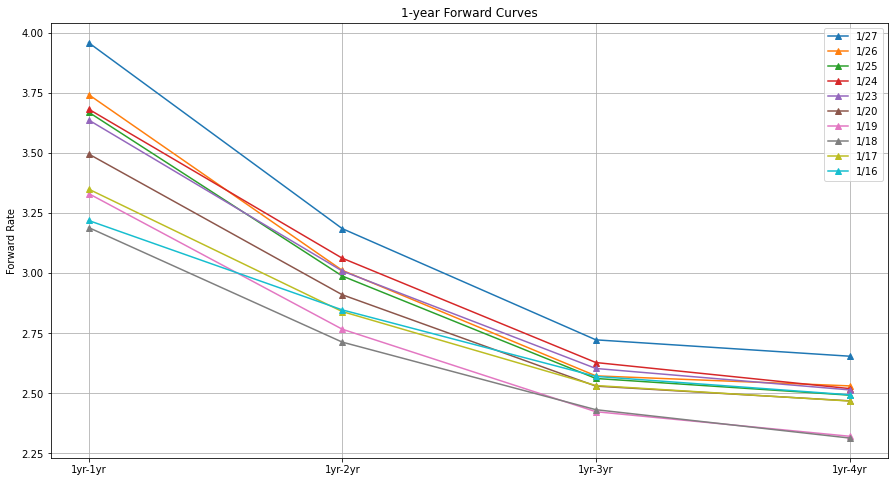

In [15]:
plt.figure(figsize=(15,8))

for i in range(len(dates)):
    plt.plot(bonds_forwards.iloc[:, i].values, label=dates[i], marker='^')
    
plt.title('1-year Forward Curves')
plt.ylabel('Forward Rate')
plt.xticks(np.arange(4),['1yr-1yr','1yr-2yr','1yr-3yr','1yr-4yr'])
plt.grid()
plt.legend()
plt.show();

### Q5: Covariance Matrices for daily log-returns of yield and forward rates

#### Covariance Matrix for daily log-returns of yield
We first calculate the covariance matrix of the random variables $X_i$ for $i=1,...,5$, where each random variable $X_i$ has the time series $X_{i,j}$ given by:
$$
X_{i,j} = log(r_{i,j+1}/r_{i,j}), j=1,...,9
$$

Each $X_{i,j}$ represents the daily log-returns of yield for bond $i$. It has a time-series (assuming time is 0th index) ranging from $t_1$ = 1/16 to $t_9$ = 1/27.  

In [36]:
bonds_ytm_arr = bonds_ytm.iloc[:, ::-1].to_numpy()
bonds_ytmR_arr = np.log(bonds_ytm_arr[:, 1:]/bonds_ytm_arr[:,:-1])
bonds_ytmR_arr

array([[-0.00786656, -0.00792893, -0.01603086, -0.00812198, -0.016426  ,
        -0.00832467, -0.01682205, -0.01712927, -0.00866616],
       [ 0.00291019, -0.01173362,  0.        ,  0.01173362, -0.0058496 ,
        -0.00882861, -0.01489687,  0.00298872,  0.00895487],
       [ 0.00947769, -0.02289919,  0.00577415,  0.01334475,  0.00566511,
         0.        , -0.01136249, -0.00190636,  0.01890205],
       [-0.00648684, -0.01802034,  0.00986489,  0.01624493,  0.00484238,
         0.00159236, -0.01452422, -0.00161567,  0.02253349],
       [-0.00519754, -0.02640083,  0.00135022,  0.02112143,  0.00912672,
         0.00517067, -0.02084505, -0.00397064,  0.0261172 ],
       [-0.00121265, -0.03401054,  0.        ,  0.01957191,  0.00605094,
         0.00119444, -0.01942923, -0.0036872 ,  0.03388701],
       [-0.01189082, -0.02637757, -0.00894944,  0.02112559,  0.0098532 ,
         0.00217648, -0.02198092, -0.00445476,  0.03077448],
       [-0.01135142, -0.0386473 , -0.00490551,  0.03306661,  0

We now have a 10x9 matrix of all bonds and their daily log-returns of yield. However, we only need $X_i$ for $i=1,...,5$. Since we are also calculating the covariance matrix for forward rates from 1yr-1yr to 1yr-4yr, we pick our 5 bonds to be the bonds used in the forward rates calculation.

In [37]:
bonds_ytmR_arr = bonds_ytmR_arr[[0,2,4,6,8], :]
bonds_ytmR_arr

array([[-0.00786656, -0.00792893, -0.01603086, -0.00812198, -0.016426  ,
        -0.00832467, -0.01682205, -0.01712927, -0.00866616],
       [ 0.00947769, -0.02289919,  0.00577415,  0.01334475,  0.00566511,
         0.        , -0.01136249, -0.00190636,  0.01890205],
       [-0.00519754, -0.02640083,  0.00135022,  0.02112143,  0.00912672,
         0.00517067, -0.02084505, -0.00397064,  0.0261172 ],
       [-0.01189082, -0.02637757, -0.00894944,  0.02112559,  0.0098532 ,
         0.00217648, -0.02198092, -0.00445476,  0.03077448],
       [-0.00944919, -0.04210978, -0.00449915,  0.03447831,  0.00520776,
        -0.00172227, -0.01310946,  0.00351914,  0.02768464]])

In [38]:
bonds_ytmR_cov = np.cov(bonds_ytmR_arr)
bonds_ytmR_cov

array([[1.98334318e-05, 9.45604719e-06, 1.66967401e-05, 1.97539963e-05,
        6.17925257e-06],
       [9.45604719e-06, 1.64456161e-04, 2.02815651e-04, 2.04462626e-04,
        2.50486953e-04],
       [1.66967401e-05, 2.02815651e-04, 3.01215652e-04, 3.22513822e-04,
        3.62995785e-04],
       [1.97539963e-05, 2.04462626e-04, 3.22513822e-04, 3.63117717e-04,
        3.95472229e-04],
       [6.17925257e-06, 2.50486953e-04, 3.62995785e-04, 3.95472229e-04,
        5.06535716e-04]])

The above forms the covariance matrix for time series of daily log-returns on yield from $X_{i,j}$ where $i=1,...,5$ and $j=1,...,9$

#### Covariance Matrix for forward rates

We do the same for our forward rates

In [43]:
bonds_forwards_arr = bonds_forwards.iloc[:, ::-1].to_numpy()
bonds_forwards_arr = np.vstack(bonds_forwards_arr[:, :]).astype(np.float)
bonds_forwards_arr

/var/folders/3q/cdf3qrtj06d84q4x0l6xslsr0000gn/T/ipykernel_1274/3335265238.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bonds_forwards_arr = np.vstack(bonds_forwards_arr[:, :]).astype(np.float)


array([[3.21940127, 3.34999317, 3.19007876, 3.33146772, 3.49620993,
        3.63765509, 3.68278324, 3.67027114, 3.74333836, 3.95932937],
       [2.84736207, 2.8404081 , 2.71326552, 2.76700092, 2.91036059,
        3.00925719, 3.06251255, 2.98833192, 3.01202385, 3.18556706],
       [2.57063868, 2.53260654, 2.43205642, 2.42366696, 2.53014015,
        2.60359007, 2.62829098, 2.56199637, 2.57283429, 2.72273878],
       [2.49398358, 2.46810455, 2.31413481, 2.32155047, 2.46892977,
        2.5144656 , 2.51989327, 2.49255093, 2.53113969, 2.65466372]])

In [44]:
forwardsReturns_arr = np.log(bonds_forwards_arr[:, 1:]/bonds_forwards_arr[:,:-1])
forwardsReturns_cov = np.cov(forwardsReturns_arr)
forwardsReturns_cov

array([[0.00108755, 0.00097181, 0.00082388, 0.00102182],
       [0.00097181, 0.0011082 , 0.00102909, 0.00113438],
       [0.00082388, 0.00102909, 0.00101776, 0.00107333],
       [0.00102182, 0.00113438, 0.00107333, 0.00132344]])

### Q6: Eigenvalues and Eigenvectors

In [48]:
ytmR_eigenvalues, ytmR_eigenvectors = np.linalg.eig(bonds_ytmR_cov)
print('Eigenvalues of daily log-returns of yield')
print(ytmR_eigenvalues)
print('Eigenvectors of daily log-returns of yield')
print(ytmR_eigenvectors)

Eigenvalues of daily log-returns of yield
[1.25713406e-03 1.34449410e-05 3.37181886e-06 4.53546152e-05
 3.58532383e-05]
Eigenvectors of daily log-returns of yield
[[-0.02048655 -0.89948251  0.06525434  0.42742017 -0.0597109 ]
 [-0.3297435   0.02726767 -0.35862245 -0.02555989 -0.87250348]
 [-0.48231294  0.2393805   0.75667417  0.34676578 -0.13141121]
 [-0.52389067  0.17546123 -0.5398372   0.48399816  0.41118548]
 [-0.61948553 -0.31952782  0.05614097 -0.67982201  0.22097484]]


In [49]:
forwardsReturns_eigenvalues, forwardsReturns_eigenvectors = np.linalg.eig(forwardsReturns_cov)
print('Eigenvalues of daily log-returns of forward rates')
print(forwardsReturns_eigenvalues)
print('Eigenvectors of daily log-returns of forward rates')
print(forwardsReturns_eigenvectors)

Eigenvalues of daily log-returns of forward rates
[4.17816080e-03 2.48758590e-04 1.25576946e-05 9.74773067e-05]
Eigenvectors of daily log-returns of forward rates
[[-0.46696095 -0.83733476 -0.26129309 -0.11199953]
 [-0.50860908  0.10900391  0.74138018 -0.42401695]
 [-0.47316787  0.50611189 -0.61465894 -0.37703753]
 [-0.54715303  0.17561151  0.06538909  0.815787  ]]
